In [1]:
#import packages, modules, and set environments
import os
import rasterio
from rasterio.mask import raster_geometry_mask
from rasterio.mask import mask
import seaborn as sns
import pandas as pdppi
import sys
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import glob
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from rasterio.mask import mask
from scipy.stats import entropy, shapiro
from scipy.stats import monte_carlo_test

warnings.filterwarnings("ignore")

#set base file path

file_path = r'D:\UNM\P50\Hudson_BGT_RWPR\TZ_stats_5724'

Polygong geometry info：
         minx       miny        maxx       maxy
0 -110.076908  36.025536 -109.845766  36.299478
Polygon bounds:          minx       miny        maxx       maxy
0 -110.076908  36.025536 -109.845766  36.299478


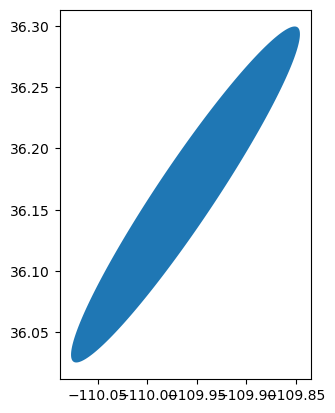

In [2]:

##read polygon file
polygon = gpd.read_file(file_path + '/Polygon/BGT_boundingBox.shp')

##plot polygon file
polygon.plot()

#get polygon geometry info

polygon_geometry_info = polygon.geometry.bounds
geometry = polygon.geometry.values[0]
print("Polygong geometry info：")
print(polygon_geometry_info)
print("Polygon bounds:", polygon.geometry.bounds)


In [3]:
#define path to raster directory


raster_path =r'D:\UNM\P50\Hudson_BGT_RWPR\TZ_stats_5724\Rasters/'

In [4]:
#check and make sure path is set correctly 

for f in os.listdir(raster_path):
    print(str(f))

_2019_125_139
_2019_223_237
_2019_299_313
_2019_300_314
_2019_322_336
_2019_323_337
_2020_026_040
_2020_041_055
_2020_043_057
_2021_248_262
_2021_252_266
_2021_268_282
_2021_269_283
_2022_001_008
_2022_064_078
_2022_065_079
_2022_083_097
_2022_149_163
_2022_150_164
_2022_247_261
_2022_248_262
_2022_331_345


In [5]:
## create functions to calculate entropy of potential exposure values

def my_entropy(x):
    return round(entropy(x.flatten(), base=2), 2)
def statistic(x):
    # Get only the `shapiro` statistic; ignore its p-value
    return stats.shapiro(x.flatten()).statistic

_2019_125_139
Min value within the polygon: 0.28681624
Max value within the polygon: 0.40158308
Median value within the polygon: 0.35073394
Sum within the polygon: 17.828823
Shapiro-Wilk test statistic: 0.9874426734274948
Shapiro-Wilk test p-value: 0.862406871238959
_2019_223_237
Min value within the polygon: 0.2226286
Max value within the polygon: 0.3316744
Median value within the polygon: 0.2829135
Sum within the polygon: 14.608095
Shapiro-Wilk test statistic: 0.9728726582960469
Shapiro-Wilk test p-value: 0.2900106586436102
_2019_299_313
Min value within the polygon: 0.17790864
Max value within the polygon: 0.35465822
Median value within the polygon: 0.26539034
Sum within the polygon: 13.747045
Shapiro-Wilk test statistic: 0.9773128502938175
Shapiro-Wilk test p-value: 0.43183088286367655
_2019_300_314
Min value within the polygon: 0.17790864
Max value within the polygon: 0.35465822
Median value within the polygon: 0.26539034
Sum within the polygon: 13.747045
Shapiro-Wilk test statist

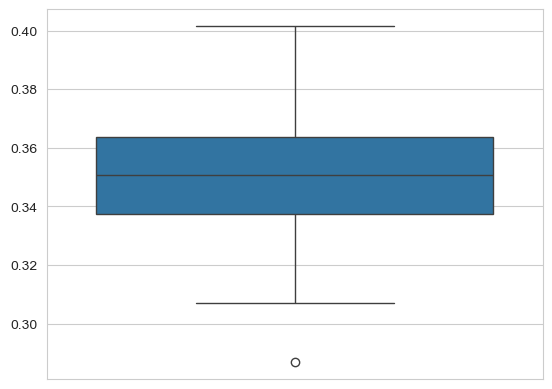

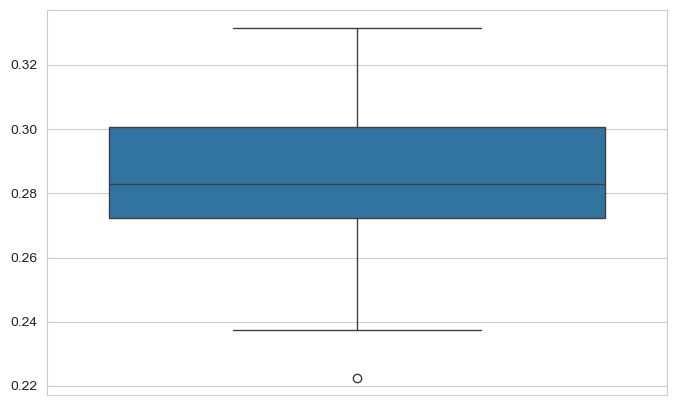

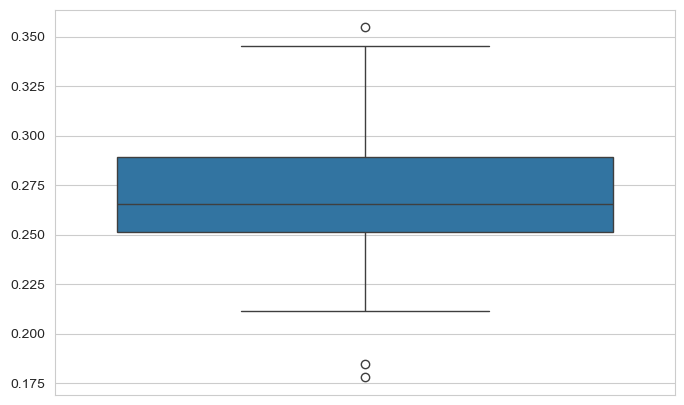

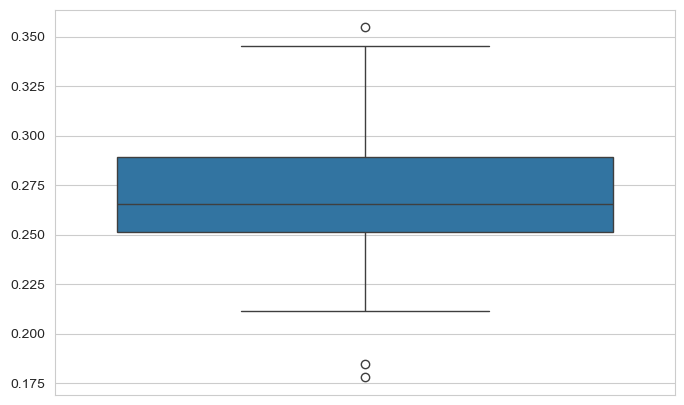

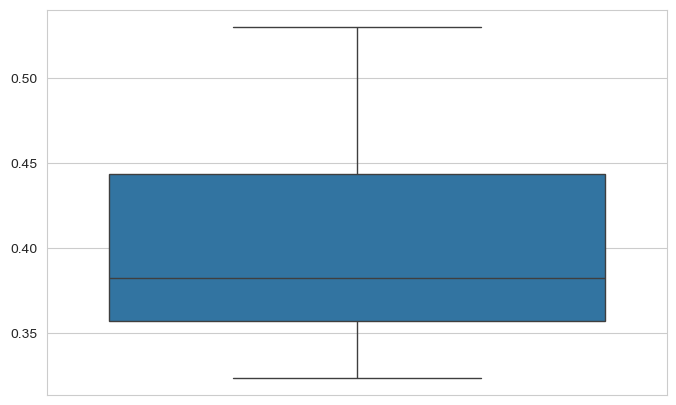

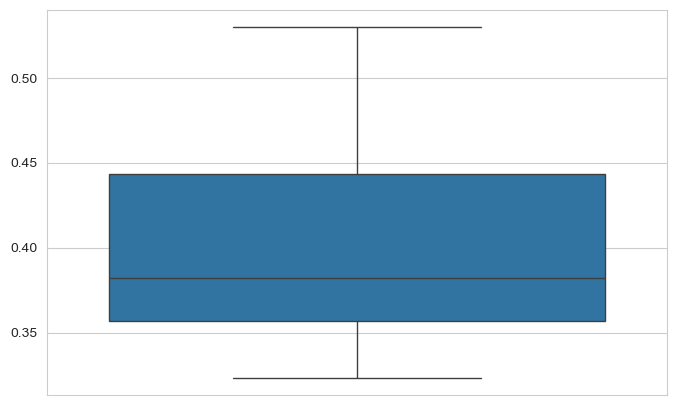

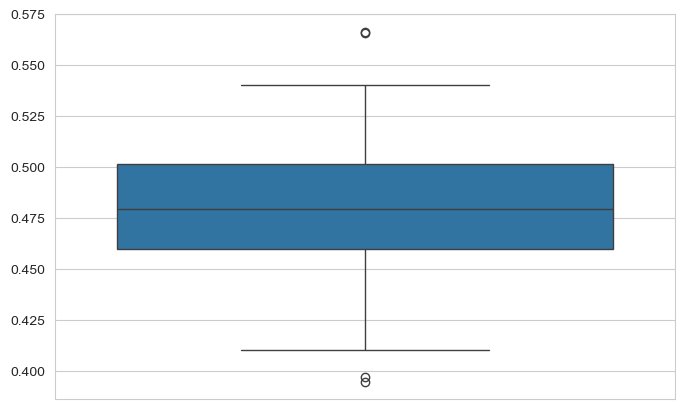

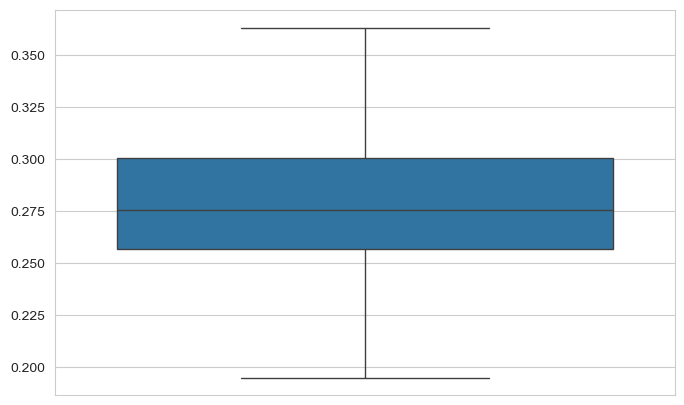

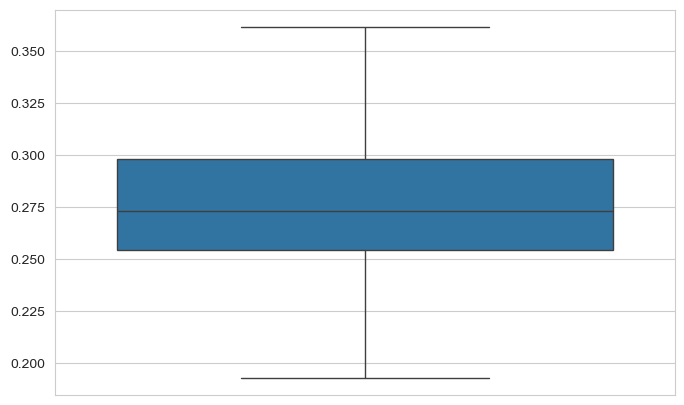

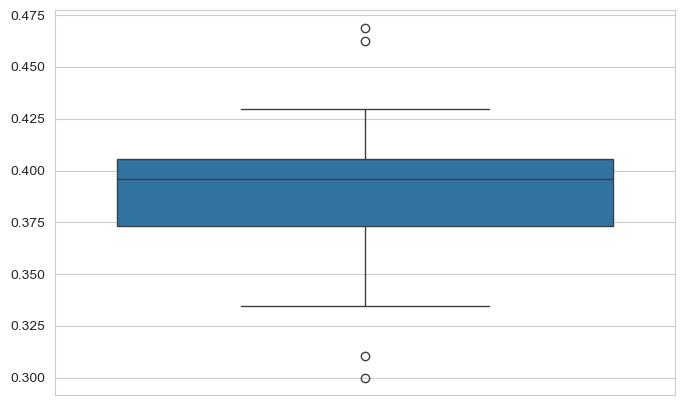

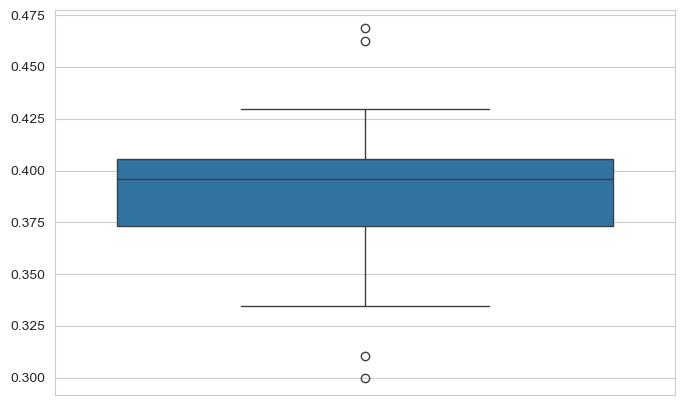

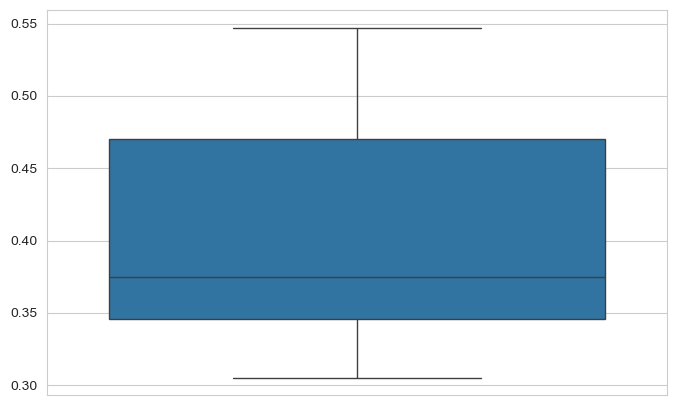

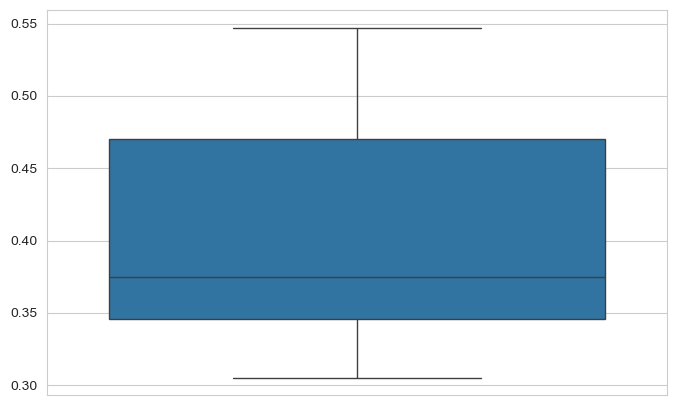

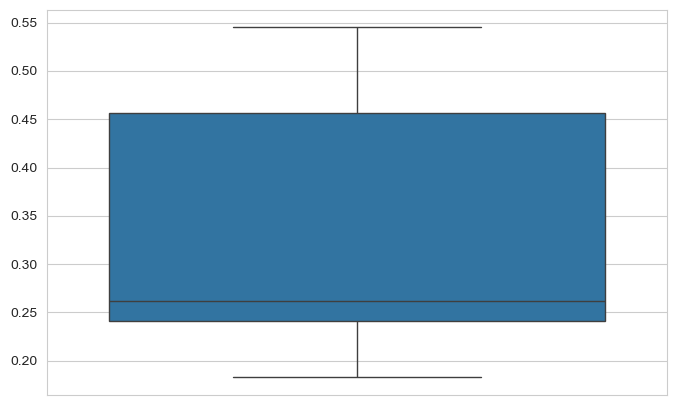

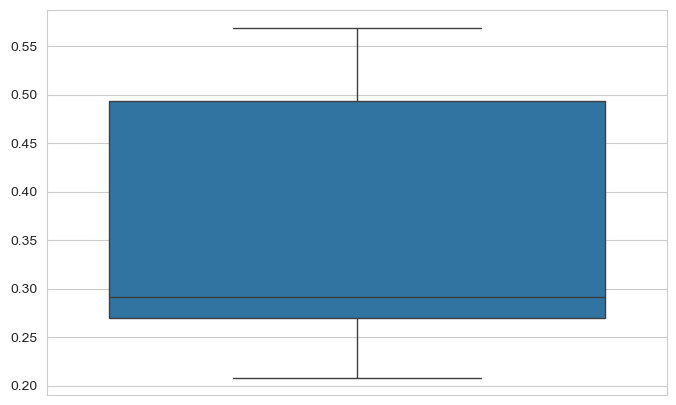

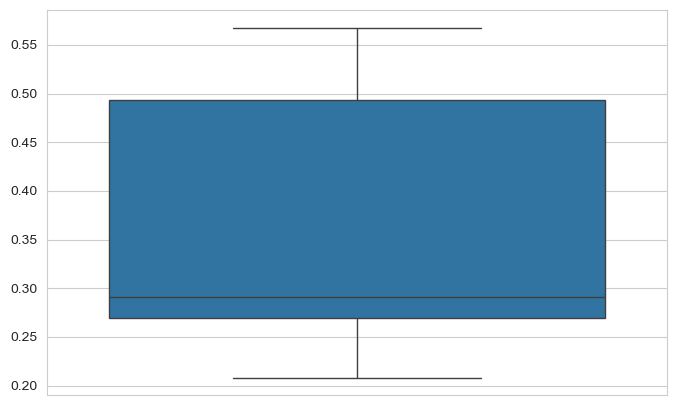

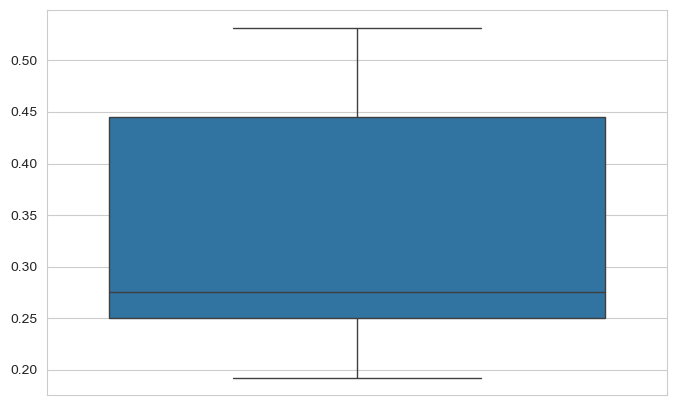

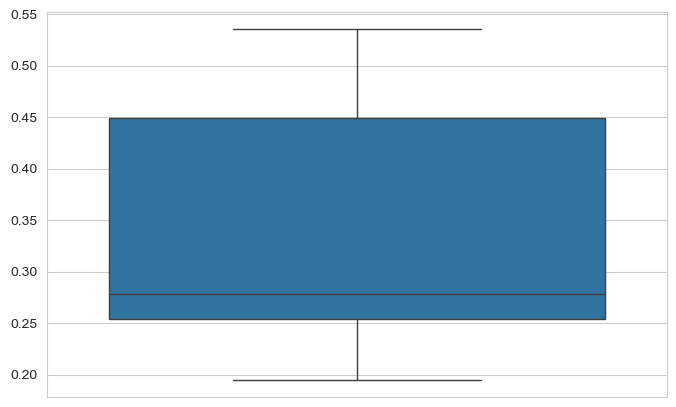

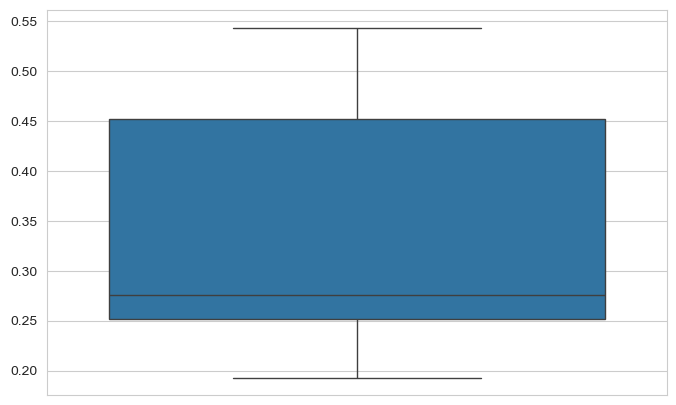

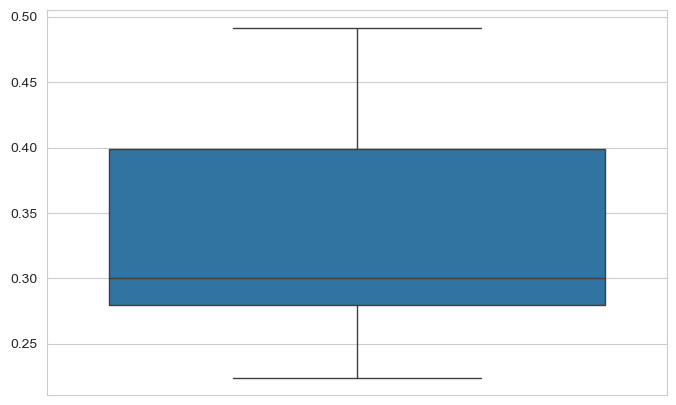

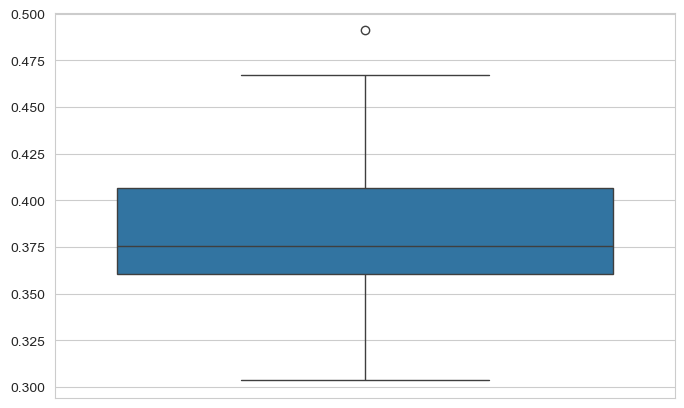

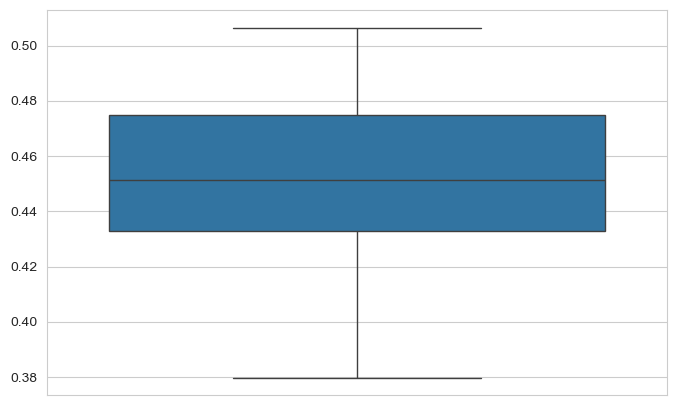

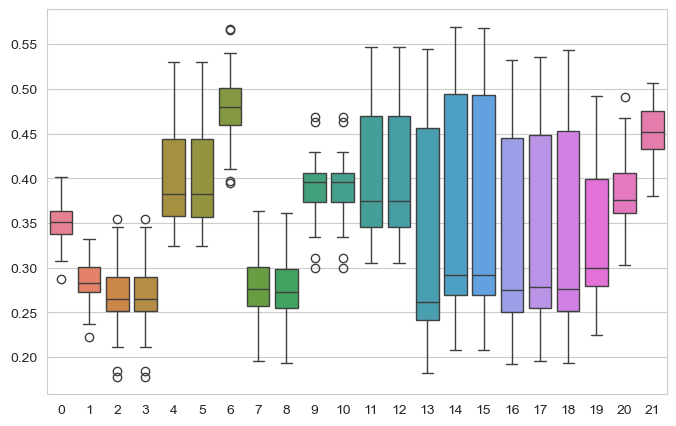

In [6]:
#Loop through all rasters. For each raster, extract array by polygon-mask, perform stats on array. Print out image of each raster with filename and stats.
all_values_list = []
file_names = [] 
entropy_values = []
iqr_values = []
skewness_values = []
kurtosis_values = []
significant_arrays = []
non_significant_arrays=[]
colors = sns.color_palette("husl", len(os.listdir(raster_path)))
sns.set_style("whitegrid")
for f in os.listdir(raster_path):
    print(str(f))
    file_names.append(str(f)) 
    newraster = rasterio.open(raster_path + f)
    out_image, out_transform = mask(newraster, [geometry], crop=True)
    masked_data = out_image[0]
    masked_data = masked_data[~np.isnan(masked_data)]
    masked_data_clean = np.delete(masked_data, np.where(masked_data < 0))
    min_value = np.min(masked_data_clean)
    max_value = np.max(masked_data_clean)
    median_value = np.median(masked_data_clean)
    sum_value = np.sum(masked_data_clean)
    print("Min value within the polygon:", min_value)
    print("Max value within the polygon:", max_value)
    print("Median value within the polygon:", median_value)
    print("Sum within the polygon:", sum_value)
    all_values_list.append(masked_data_clean)
    ##transfering all_values to array 
    all_values_array = np.array(all_values_list)
    sns.boxplot(data=masked_data_clean, orient='v')
    ##sns.boxplot(y=values)
    
    ##calculating entropy_value
    entropy_value = my_entropy(masked_data_clean)
    entropy_values.append(entropy_value)
    
    shapiro_res = shapiro(masked_data_clean)
    print("Shapiro-Wilk test statistic:", shapiro_res.statistic)
    print("Shapiro-Wilk test p-value:", shapiro_res.pvalue)
    
    # create the graph
    fig, ax = plt.subplots(figsize=(8, 5))
    bins = np.linspace(0.65, 1, 50)
     
    # calculate Shapiro value
    ref = scipy.stats.monte_carlo_test(masked_data_clean, stats.norm.rvs, statistic, alternative='two-sided')
  
    # Perform Shapiro-Wilk test for normality
    shapiro_results = [shapiro(data) for data in all_values_array]
    p_values = np.array([result.pvalue for result in shapiro_results])
    all_values_array_transposed = np.transpose(all_values_array)
    # Perform ANOVA or Kruskal-Wallis test based on Shapiro-Wilk test results
for p_value ,array in zip(p_values, all_values_array_transposed):   
    if p_value > 0.05:
        significant_arrays.append(array)
if significant_arrays:
    print(" significant arrays found.")
    f_statistic, p_value = stats.f_oneway(*significant_arrays)
    print("F-statistic:", f_statistic)
    print("P-value:", p_value)

sns.boxplot(data=all_values_list, orient='v')
H, p = stats.kruskal(*all_values_list)
print("Kruskal-Wallis H statistic:", H)
print("Kruskal-Wallis p-value:", p)
